<a href="https://colab.research.google.com/github/CrazyTiger8903/Study_Pytorch/blob/main/bert_multiclassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf

# Get the GPU device name.
device_name = tf.test.gpu_device_name()

# The device name should look like the following:
if device_name == '/device:GPU:0':
    print('Found GPU at: {}'.format(device_name))
else:
    raise SystemError('GPU device not found')

Found GPU at: /device:GPU:0


In [ ]:
import torch

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [ ]:
!pip install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.9/7.9 MB 44.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.1/311.1 kB 26.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 83.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 35.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 27.4 MB/s eta 0:00:00


In [ ]:
import json

# JSON 파일 읽기 및 데이터 추출
def extract_captions_labels(json_file_path, num_samples = None):
    with open(json_file_path, "r") as json_file:
        data = json.load(json_file)

    captions_labels = []
    annotations = data["annotations"]

    if num_samples is not None:
        annotations = annotations[:num_samples]

    for annotation in annotations:
        caption = annotation["caption"]
        label = annotation["danger_score"]
        captions_labels.append((caption, label))

    return captions_labels

# file1.json에서 데이터 추출
file1_captions_labels = extract_captions_labels("/content/drive/MyDrive/train_abnormal_dataset.json")

# file2.json에서 2500개 데이터 추출
file2_captions_labels = extract_captions_labels("/content/drive/MyDrive/your_modified_file.json", 500)

# 두 데이터 리스트를 합치기
captions_labels = file1_captions_labels + file2_captions_labels

print(len(captions_labels))

captions_labels = list(set(captions_labels))

print(len(captions_labels))

2591
2400


In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

# 데이터 분리
sentences, labels = zip(*captions_labels)

In [ ]:
from transformers import BertTokenizer

# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [ ]:
# Print the original sentence.
print(' Original: ', sentences[0])

# Print the sentence split into tokens.
print('Tokenized: ', tokenizer.tokenize(sentences[0]))

# Print the sentence mapped to token ids.
print('Token IDs: ', tokenizer.convert_tokens_to_ids(tokenizer.tokenize(sentences[0])))

 Original:  A man in black clothes is punching a man in suit indoors.
Tokenized:  ['a', 'man', 'in', 'black', 'clothes', 'is', 'punching', 'a', 'man', 'in', 'suit', 'indoors', '.']
Token IDs:  [1037, 2158, 1999, 2304, 4253, 2003, 19477, 1037, 2158, 1999, 4848, 24274, 1012]


In [ ]:
max_len = 0

# For every sentence...
for sent in sentences:

    # Tokenize the text and add `[CLS]` and `[SEP]` tokens.
    input_ids = tokenizer.encode(sent, add_special_tokens=True)

    # Update the maximum sentence length.
    max_len = max(max_len, len(input_ids))

print('Max sentence length: ', max_len)

Max sentence length:  35


In [ ]:
# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
labels = torch.tensor(labels)

# Print sentence 0, now as a list of IDs.
print('Original: ', sentences[0])
print('Token IDs:', input_ids[0])

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


Original:  A man in black clothes is punching a man in suit indoors.
Token IDs: tensor([  101,  1037,  2158,  1999,  2304,  4253,  2003, 19477,  1037,  2158,
         1999,  4848, 24274,  1012,   102,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0])


In [ ]:
from torch.utils.data import TensorDataset, random_split

# Combine the training inputs into a TensorDataset.
dataset = TensorDataset(input_ids, attention_masks, labels)

# Create a 90-10 train-validation split.

# Calculate the number of samples to include in each set.
train_size = int(0.99 * len(dataset))
val_size = len(dataset) - train_size

# Divide the dataset by randomly selecting samples.
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

2,376 training samples
   24 validation samples


In [ ]:
from torch.utils.data import DataLoader, RandomSampler, SequentialSampler

# The DataLoader needs to know our batch size for training, so we specify it
# here. For fine-tuning BERT on a specific task, the authors recommend a batch
# size of 16 or 32.
batch_size = 32

# Create the DataLoaders for our training and validation sets.
# We'll take training samples in random order.
train_dataloader = DataLoader(
            train_dataset,  # The training samples.
            sampler = RandomSampler(train_dataset), # Select batches randomly
            batch_size = batch_size # Trains with this batch size.
        )

# For validation the order doesn't matter, so we'll just read them sequentially.
validation_dataloader = DataLoader(
            val_dataset, # The validation samples.
            sampler = SequentialSampler(val_dataset), # Pull out batches sequentially.
            batch_size = batch_size # Evaluate with this batch size.
        )

In [ ]:
from transformers import BertForSequenceClassification, AdamW, BertConfig

# Load BertForSequenceClassification, the pretrained BERT model with a single
# linear classification layer on top.
model = BertForSequenceClassification.from_pretrained(
    "bert-base-uncased", # Use the 12-layer BERT model, with an uncased vocab.
    num_labels = 8, # The number of output labels--2 for binary classification.
                    # You can increase this for multi-class tasks.
    output_attentions = False, # Whether the model returns attentions weights.
    output_hidden_states = False, # Whether the model returns all hidden-states.
)

# Tell pytorch to run this model on the GPU.
model.cuda()

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [ ]:
# Note: AdamW is a class from the huggingface library (as opposed to pytorch)
# I believe the 'W' stands for 'Weight Decay fix"
optimizer = AdamW(model.parameters(),
                  lr = 2e-5, # args.learning_rate - default is 5e-5, our notebook had 2e-5
                  eps = 1e-8 # args.adam_epsilon  - default is 1e-8.
                )


/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
from transformers import get_linear_schedule_with_warmup

# Number of training epochs. The BERT authors recommend between 2 and 4.
# We chose to run for 4, but we'll see later that this may be over-fitting the
# training data.
epochs = 4

# Total number of training steps is [number of batches] x [number of epochs].
# (Note that this is not the same as the number of training samples).
total_steps = len(train_dataloader) * epochs

# Create the learning rate scheduler.
scheduler = get_linear_schedule_with_warmup(optimizer,
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [ ]:
import numpy as np

# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [ ]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    # Round to the nearest second.
    elapsed_rounded = int(round((elapsed)))

    # Format as hh:mm:ss
    return str(datetime.timedelta(seconds=elapsed_rounded))


In [ ]:
import random
import numpy as np

# This training code is based on the `run_glue.py` script here:
# https://github.com/huggingface/transformers/blob/5bfcd0485ece086ebcbed2d008813037968a9e58/examples/run_glue.py#L128

# Set the seed value all over the place to make this reproducible.
seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

# We'll store a number of quantities such as training and validation loss,
# validation accuracy, and timings.
training_stats = []

# Measure the total training time for the whole run.
total_t0 = time.time()

# For each epoch...
for epoch_i in range(0, epochs):

    # ========================================
    #               Training
    # ========================================

    # Perform one full pass over the training set.

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    print('Training...')

    # Measure how long the training epoch takes.
    t0 = time.time()

    # Reset the total loss for this epoch.
    total_train_loss = 0

    # Put the model into training mode. Don't be mislead--the call to
    # `train` just changes the *mode*, it doesn't *perform* the training.
    # `dropout` and `batchnorm` layers behave differently during training
    # vs. test (source: https://stackoverflow.com/questions/51433378/what-does-model-train-do-in-pytorch)
    model.train()

    # For each batch of training data...
    for step, batch in enumerate(train_dataloader):

        # Progress update every 40 batches.
        if step % 40 == 0 and not step == 0:
            # Calculate elapsed time in minutes.
            elapsed = format_time(time.time() - t0)

            # Report progress.
            print('  Batch {:>5,}  of  {:>5,}.    Elapsed: {:}.'.format(step, len(train_dataloader), elapsed))

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using the
        # `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Always clear any previously calculated gradients before performing a
        # backward pass. PyTorch doesn't do this automatically because
        # accumulating the gradients is "convenient while training RNNs".
        # (source: https://stackoverflow.com/questions/48001598/why-do-we-need-to-call-zero-grad-in-pytorch)
        model.zero_grad()

        # Perform a forward pass (evaluate the model on this training batch).
        # In PyTorch, calling `model` will in turn call the model's `forward`
        # function and pass down the arguments. The `forward` function is
        # documented here:
        # https://huggingface.co/transformers/model_doc/bert.html#bertforsequenceclassification
        # The results are returned in a results object, documented here:
        # https://huggingface.co/transformers/main_classes/output.html#transformers.modeling_outputs.SequenceClassifierOutput
        # Specifically, we'll get the loss (because we provided labels) and the
        # "logits"--the model outputs prior to activation.
        result = model(b_input_ids,
                       token_type_ids=None,
                       attention_mask=b_input_mask,
                       labels=b_labels,
                       return_dict=True)

        loss = result.loss
        logits = result.logits

        # Accumulate the training loss over all of the batches so that we can
        # calculate the average loss at the end. `loss` is a Tensor containing a
        # single value; the `.item()` function just returns the Python value
        # from the tensor.
        total_train_loss += loss.item()

        # Perform a backward pass to calculate the gradients.
        loss.backward()

        # Clip the norm of the gradients to 1.0.
        # This is to help prevent the "exploding gradients" problem.
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)

        # Update parameters and take a step using the computed gradient.
        # The optimizer dictates the "update rule"--how the parameters are
        # modified based on their gradients, the learning rate, etc.
        optimizer.step()

        # Update the learning rate.
        scheduler.step()

    # Calculate the average loss over all of the batches.
    avg_train_loss = total_train_loss / len(train_dataloader)

    # Measure how long this epoch took.
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epcoh took: {:}".format(training_time))

    # ========================================
    #               Validation
    # ========================================
    # After the completion of each training epoch, measure our performance on
    # our validation set.

    print("")
    print("Running Validation...")

    t0 = time.time()

    # Put the model in evaluation mode--the dropout layers behave differently
    # during evaluation.
    model.eval()

    # Tracking variables
    total_eval_accuracy = 0
    total_eval_loss = 0
    nb_eval_steps = 0

    # Evaluate data for one epoch
    for batch in validation_dataloader:

        # Unpack this training batch from our dataloader.
        #
        # As we unpack the batch, we'll also copy each tensor to the GPU using
        # the `to` method.
        #
        # `batch` contains three pytorch tensors:
        #   [0]: input ids
        #   [1]: attention masks
        #   [2]: labels
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)

        # Tell pytorch not to bother with constructing the compute graph during
        # the forward pass, since this is only needed for backprop (training).
        with torch.no_grad():

            # Forward pass, calculate logit predictions.
            # token_type_ids is the same as the "segment ids", which
            # differentiates sentence 1 and 2 in 2-sentence tasks.
            result = model(b_input_ids,
                           token_type_ids=None,
                           attention_mask=b_input_mask,
                           labels=b_labels,
                           return_dict=True)

        # Get the loss and "logits" output by the model. The "logits" are the
        # output values prior to applying an activation function like the
        # softmax.
        loss = result.loss
        logits = result.logits

        # Accumulate the validation loss.
        total_eval_loss += loss.item()

        # Move logits and labels to CPU
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()

        # Calculate the accuracy for this batch of test sentences, and
        # accumulate it over all batches.
        total_eval_accuracy += flat_accuracy(logits, label_ids)


    # Report the final accuracy for this validation run.
    avg_val_accuracy = total_eval_accuracy / len(validation_dataloader)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    # Calculate the average loss over all of the batches.
    avg_val_loss = total_eval_loss / len(validation_dataloader)

    # Measure how long the validation run took.
    validation_time = format_time(time.time() - t0)

    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    # Record all statistics from this epoch.
    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")

print("Total training took {:} (h:mm:ss)".format(format_time(time.time()-total_t0)))


======== Epoch 1 / 4 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:17.

  Average training loss: 1.43
  Training epcoh took: 0:00:28

Running Validation...
  Accuracy: 0.75
  Validation Loss: 0.82
  Validation took: 0:00:00

======== Epoch 2 / 4 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:13.

  Average training loss: 0.74
  Training epcoh took: 0:00:25

Running Validation...
  Accuracy: 0.79
  Validation Loss: 0.64
  Validation took: 0:00:00

======== Epoch 3 / 4 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:13.

  Average training loss: 0.51
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.53
  Validation took: 0:00:00

======== Epoch 4 / 4 ========
Training...
  Batch    40  of     75.    Elapsed: 0:00:13.

  Average training loss: 0.43
  Training epcoh took: 0:00:24

Running Validation...
  Accuracy: 0.83
  Validation Loss: 0.50
  Validation took: 0:00:00

Training complete!
Total tr

In [ ]:
import pandas as pd

# Display floats with two decimal places.
#pd.set_option('precision', 2)

# Create a DataFrame from our training statistics.
df_stats = pd.DataFrame(data=training_stats)

# Use the 'epoch' as the row index.
df_stats = df_stats.set_index('epoch')

# A hack to force the column headers to wrap.
#df = df.style.set_table_styles([dict(selector="th",props=[('max-width', '70px')])])

# Display the table.
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.434333,0.820607,0.750000,0:00:28,0:00:00
2,0.736368,0.635698,0.791667,0:00:25,0:00:00
3,0.509889,0.530491,0.833333,0:00:24,0:00:00
4,0.427028,0.496845,0.833333,0:00:24,0:00:00


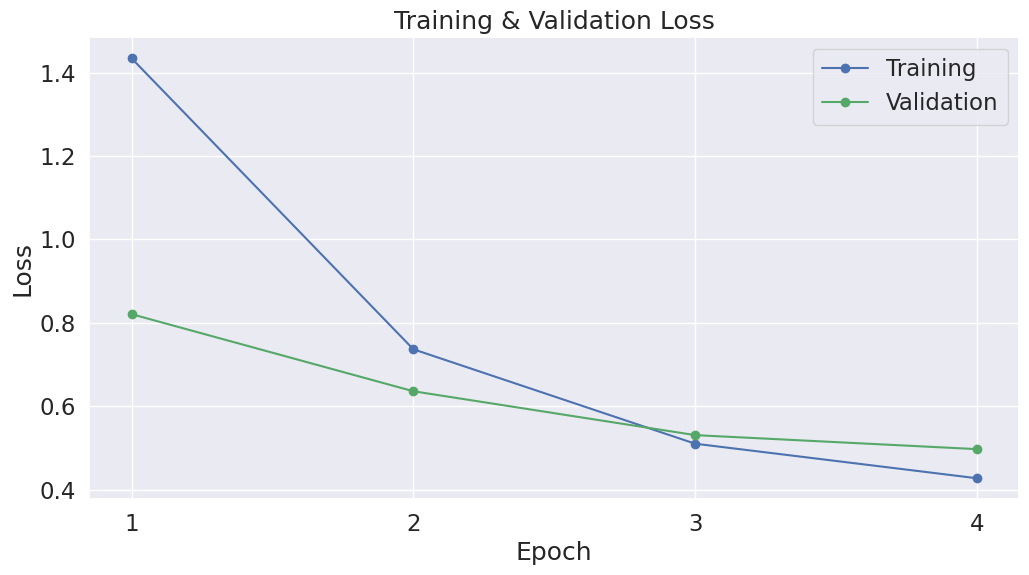

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Use plot styling from seaborn.
sns.set(style='darkgrid')

# Increase the plot size and font size.
sns.set(font_scale=1.5)
plt.rcParams["figure.figsize"] = (12,6)

# Plot the learning curve.
plt.plot(df_stats['Training Loss'], 'b-o', label="Training")
plt.plot(df_stats['Valid. Loss'], 'g-o', label="Validation")

# Label the plot.
plt.title("Training & Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.xticks([1, 2, 3, 4])

plt.show()

In [ ]:
# Save the trained model and its configuration to a directory
model.save_pretrained('/content/drive/MyDrive/blip_mc')

# Save the tokenizer used for training
tokenizer.save_pretrained('/content/drive/MyDrive/blip_mc')

('/content/drive/MyDrive/blip_mc/tokenizer_config.json',
 '/content/drive/MyDrive/blip_mc/special_tokens_map.json',
 '/content/drive/MyDrive/blip_mc/vocab.txt',
 '/content/drive/MyDrive/blip_mc/added_tokens.json')

In [ ]:
# 입력 문장 리스트
# sentences = ["there is a woman laying on the floor in front of a tv.",
#              "there is a woman laying on the floor.",
#              "there is a woman laying on the floor in front of a door.",
#              "there is a man laying on the floor in front of a tv.",
#              "there is a woman laying in the warehouse.",
#              "there is a woman laying on the floor in front of desk."
#              ]

# 입력 문장 리스트
sentences = ["Two men are fighting indoors.",
               "A man in a red jacket is being assaulted on the street by a man in a hat.",
               "A woman is laying on the street.",
               "One person is pass out in the warehouse.",
               "They are eating apple in the house.",
               "People are walking down the street.",
               "A group of friends enjoying a sunny day at the beach.",
               "there is a man that is holding a man's neck in a room.",
               "they are playing a game of wii in a room with a red screen.",
               "there is a man kicking a woman in a hallway.",
             "araffes and a man are fighting in a room.",
             "there are many people in a classroom with desks and chairs.",
             "there is a woman laying on the floor in front of a tv.",
             "there is a woman laying on the floor.",
             "a woman is lying on the floor.",
             "a man is sleeping on the bed.",
             "there is a man and a woman playing with a frisbee.",
             "several men are fighting in a group in front of a building.",
             "woman sitting in a white sports car with her dog.",
             "there are two people wearing masks walking down the street.",
             "several people sitting on a bench playing musical instruments together.",
             "there is a man kicking ball.",
             "there are two people walking down the street.",
             "there is a man walking down the street.",
             "there is a man sleeping on the street.",
             "there are two people eating noodle.",
             "there are two people playing baseball."
             ]

# Tokenize all of the sentences and map the tokens to thier word IDs.
input_ids = []
attention_masks = []

# For every sentence...
for sent in sentences:
    # `encode_plus` will:
    #   (1) Tokenize the sentence.
    #   (2) Prepend the `[CLS]` token to the start.
    #   (3) Append the `[SEP]` token to the end.
    #   (4) Map tokens to their IDs.
    #   (5) Pad or truncate the sentence to `max_length`
    #   (6) Create attention masks for [PAD] tokens.
    encoded_dict = tokenizer.encode_plus(
                        sent,                      # Sentence to encode.
                        add_special_tokens = True, # Add '[CLS]' and '[SEP]'
                        max_length = 64,           # Pad & truncate all sentences.
                        pad_to_max_length = True,
                        return_attention_mask = True,   # Construct attn. masks.
                        return_tensors = 'pt',     # Return pytorch tensors.
                   )

    # Add the encoded sentence to the list.
    input_ids.append(encoded_dict['input_ids'])

    # And its attention mask (simply differentiates padding from non-padding).
    attention_masks.append(encoded_dict['attention_mask'])

# Convert the lists into tensors.
input_ids = torch.cat(input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)

/usr/local/lib/python3.10/dist-packages/transformers/tokenization_utils_base.py:2614: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


In [ ]:
import torch.nn.functional as F
from transformers import BertForSequenceClassification, BertTokenizer

# Load the saved model and tokenizer
model = BertForSequenceClassification.from_pretrained('/content/drive/MyDrive/blip_mc')
tokenizer = BertTokenizer.from_pretrained('/content/drive/MyDrive/blip_mc')
# Set the device for inference
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# 입력 문장 리스트
sentences = ["Two men are fighting indoors.",
               "A man in a red jacket is being assaulted on the street by a man in a hat.",
               "A woman is laying on the street.",
               "One person is pass out in the warehouse.",
               "They are eating apple in the house.",
               "People are walking down the street.",
               "A group of friends enjoying a sunny day at the beach.",
               "there is a man that is holding a man's neck in a room.",
               "they are playing a game of wii in a room with a red screen.",
               "there is a man kicking a woman in a hallway.",
             "araffes and a man are fighting in a room.",
             "there are many people in a classroom with desks and chairs.",
             "there is a woman laying on the floor in front of a tv.",
             "there is a woman laying on the floor.",
             "a woman is lying on the floor.",
             "a man is sleeping on the bed.",
             "there is a man and a woman playing with a frisbee.",
             "several men are fighting in a group in front of a building.",
             "woman sitting in a white sports car with her dog.",
             "there are two people wearing masks walking down the street.",
             "several people sitting on a bench playing musical instruments together.",
             "there is a man kicking ball.",
             "there are two people walking down the street.",
             "there is a man walking down the street.",
             "there is a man sleeping on the street.",
             "there are two people eating noodle.",
             "there are two people playing baseball."
             ]

# Tokenize and prepare input
inputs = tokenizer(sentences, padding=True, truncation=True, return_tensors="pt")
input_ids = inputs["input_ids"].to(device)
attention_mask = inputs["attention_mask"].to(device)

# Inference
model.eval()
with torch.no_grad():
    inputs = {"input_ids": input_ids, "attention_mask": attention_mask}
    outputs = model(**inputs)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim=1)

label_map = {0: 'Label_0(정상)', 1: 'Label_1(위험)', 2: 'Label_2(위험)', 3: 'Label_3(위험)', 4: 'Label_4(위험)', 5: 'Label_5(위험)', 6: 'Label_6(위험)', 7: 'Label_7(위험)'}

for i, text in enumerate(sentences):
    print(f"Input: {text}")
    max_label_id = torch.argmax(probabilities[i]).item()
    max_label_name = label_map[max_label_id]
    max_label_probability = probabilities[i][max_label_id].item()

    print(f"Predicted Label: {max_label_name}")
    for label_id in range(8):
        label_name = label_map[label_id]
        label_probability = probabilities[i][label_id].item()
        print(f"{label_name} Probability: {label_probability:.4f}")
    print("="*50)

Input: Two men are fighting indoors.
Predicted Label: Label_5(위험)
Label_0(정상) Probability: 0.0068
Label_1(위험) Probability: 0.0070
Label_2(위험) Probability: 0.0055
Label_3(위험) Probability: 0.0045
Label_4(위험) Probability: 0.0073
Label_5(위험) Probability: 0.9241
Label_6(위험) Probability: 0.0168
Label_7(위험) Probability: 0.0279
Input: A man in a red jacket is being assaulted on the street by a man in a hat.
Predicted Label: Label_5(위험)
Label_0(정상) Probability: 0.0059
Label_1(위험) Probability: 0.0079
Label_2(위험) Probability: 0.0077
Label_3(위험) Probability: 0.0069
Label_4(위험) Probability: 0.0060
Label_5(위험) Probability: 0.7759
Label_6(위험) Probability: 0.1019
Label_7(위험) Probability: 0.0877
Input: A woman is laying on the street.
Predicted Label: Label_5(위험)
Label_0(정상) Probability: 0.0042
Label_1(위험) Probability: 0.0068
Label_2(위험) Probability: 0.0070
Label_3(위험) Probability: 0.0053
Label_4(위험) Probability: 0.0064
Label_5(위험) Probability: 0.7555
Label_6(위험) Probability: 0.1368
Label_7(위험) Probabi

In [ ]:
import torch.nn.functional as F
# 추론을 위해 모델 사용
model.eval()
with torch.no_grad():
    input_ids = input_ids.to(device)
    attention_masks = attention_masks.to(device)
    outputs = model(input_ids, attention_mask=attention_masks)
    logits = outputs.logits
    probabilities = F.softmax(logits, dim=1)
    predicted_labels = torch.argmax(logits, dim=1)

label_map = {0: 'Label_0(정상)', 1: 'Label_1(위험)', 2: 'Label_2(위험)', 3: 'Label_3(위험)', 4: 'Label_4(위험)', 5: 'Label_5(위험)', 6: 'Label_6(위험)', 7: 'Label_7(위험)'}

for i, text in enumerate(sentences):
    print(f"Input: {text}")
    max_label_id = torch.argmax(probabilities[i]).item()
    max_label_name = label_map[max_label_id]
    max_label_probability = probabilities[i][max_label_id].item()

    print(f"Predicted Label: {max_label_name}")
    for label_id in range(8):
        label_name = label_map[label_id]
        label_probability = probabilities[i][label_id].item()
        print(f"{label_name} Probability: {label_probability:.4f}")
    print("="*50)


Input: Two men are fighting indoors.
Predicted Label: Label_5(위험)
Label_0(정상) Probability: 0.0068
Label_1(위험) Probability: 0.0070
Label_2(위험) Probability: 0.0055
Label_3(위험) Probability: 0.0045
Label_4(위험) Probability: 0.0073
Label_5(위험) Probability: 0.9241
Label_6(위험) Probability: 0.0168
Label_7(위험) Probability: 0.0279
Input: A man in a red jacket is being assaulted on the street by a man in a hat.
Predicted Label: Label_5(위험)
Label_0(정상) Probability: 0.0059
Label_1(위험) Probability: 0.0079
Label_2(위험) Probability: 0.0077
Label_3(위험) Probability: 0.0069
Label_4(위험) Probability: 0.0060
Label_5(위험) Probability: 0.7759
Label_6(위험) Probability: 0.1019
Label_7(위험) Probability: 0.0877
Input: A woman is laying on the street.
Predicted Label: Label_5(위험)
Label_0(정상) Probability: 0.0042
Label_1(위험) Probability: 0.0068
Label_2(위험) Probability: 0.0070
Label_3(위험) Probability: 0.0053
Label_4(위험) Probability: 0.0064
Label_5(위험) Probability: 0.7555
Label_6(위험) Probability: 0.1368
Label_7(위험) Probabi